## $\text{C}_n\text{NOT}_e$ Gate optimization for Nitrogen-vacancy center and $^{13}\text{C}$-nuclear spin system

Single qubit Gates along with the Controlled-NOT (CNOT) form the universal set of operation for quantum computers, and are essential for diamond based processors. The electron spin Nitrogen-vacancy (NV) center defects can optically initialized and read out, and it's interaction with the nuclear spins in the lattice paves the way for multi-qubit systems. This notebook gives a simple example of performing a CNOT Gate optimization using the QuOCS package. A single $^{13}\text{C}$-nuclear spin and a NV center spin are included in the model. In the presence of an external bias magnetic field $\vec{B}$, the Hamiltonian for the spin system can be described as:

$$\begin{equation}\hat{H} =\overbrace{\hbar D\left[\hat{S}_Z^2-\frac{2}{3}\right]}^\text{NV zero-field term} + \overbrace{\hbar\gamma_{nv}\vec{B}\cdot{\vec{S}}}^\text{NV Zeeman interaction}\nonumber+\hbar{{\sum}}_{i=1}^{n}\left(\overbrace{{\vec{S}}\mathcal{A}_i{\vec{I}}_i}^\text{coupling interactions}+\overbrace{\gamma_i\vec{B}\cdot{\vec{I}}_i}^\text{nuclear Zeeman interactions}\right),\end{equation} $$

where $D$=2.87 GHz is the NV zero field parameter, $\hbar$ i the reduces Plank's constant, $\gamma_{nv}$, and $\gamma_i$ are the NV and nuclear spin gyromagentic rations, respectively. Additionally, $\vec{S}$ = $[\hat{S}_X, \hat{S}_Y, \hat{S}_Z]$ and  $\vec{I}$ = $[\hat{I}_X, \hat{I}_Y, \hat{I}_Z]$ denote the NV and nuclear spin matrices, respectively. Finally, $\mathcal{A}$ is the spin coupling tensor (Hyperfine tensor in this case). The index $i$ iterates over the different nuclear spin in the system.

In the following, so called ZZ-coupling is assumed to be the only interaction between the spins. Additionally, the Nitrogen nuclear spin degree of freedom is ignored (i.e., polarized spin state) such that only the dynamics of the $^{13}\text{C}$-nucleus and the NV spin are relevant to the problem. To further simplify the dynamics, the NV is assumed to be a pseudo two-level, which holds true when $\gamma_{nv}|B|$ is sufficiently large. Assuming the $m_s = 1\leftrightarrow 0$ to be the electron spin qubit transition, the Hamiltoninan is calculated in its rotating frame.

---

> Author- Nimba Oshnik and Matthias Müller
>
> © 2024-  QuOCS Team
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>    http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

from scipy.linalg import expm
from scipy.linalg import sqrtm
import numpy as np
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
from quocslib.Optimizer import Optimizer
import time
import functools

#### Define system Hamiltonian

(for simplicity, $\hbar$ = 1)

In [ ]:
# units - ns, GHz, T


def tensor_together(A):
        """Takes a list of matrices and multiplies them together with the tensor product"""
        res = A[0]
        if len(A) > 1:
            res = np.kron(A[0], A[1])
        if len(A) > 2:
            for two in A[2:]:
                res = np.kron(res, two)
        else:
            res = res
        return res
    

def drift_Hamiltonian():
    """Function returns the static Hamiltoninan in the NV rotating frame
    Additionally returns set of spin matrices and constant the forms 
    the static Hamiltonian"""
    
    B = 1e-2  # Modify to change the magnituce of the aligned magnetic field; to change the larmour precession of the nuclear spin
    ge = 28; #gamma nv
    gn = 10.7e-3 #gamma nuclear spin
    
    # Definition of constant matrices

    # TLS NV system
    NVsx = 0.5*np.array([[0, 1], [1, 0]], dtype="complex")
    NVsy = 0.5j*np.array([[0, -1], [1, 0]], dtype="complex")
    NVsz = 0.5*np.array([[1, 0], [0, -1]], dtype="complex")
    NVidy = np.eye(2)
    NVup = 0.5*np.array([[1, 0], [0, 0]], dtype="complex")
    
    # 13C spin matrices 
    Ix = 0.5*np.array([[0, 1], [1, 0]], dtype="complex")
    Iy = 0.5j*np.array([[0, -1], [1, 0]], dtype="complex")
    Iz = 0.5*np.array([[1, 0], [0, -1]], dtype="complex")
    I_idy = np.eye(2)
    
    # Define spin matrices for the entire system 
    Idy_mat = [] 
    Sx_mat = []
    Sy_mat = [] 
    Sz_mat = []
    gyro = []


    Idy_mat.append(NVidy)
    Sx_mat.append(NVsx)
    Sy_mat.append(NVsy)
    Sz_mat.append(NVsz)
    gyro.append(ge);
    
    Idy_mat.append(I_idy)
    Sx_mat.append(Ix)
    Sy_mat.append(Iy)
    Sz_mat.append(Iz)
    gyro.append(gn)
    
    # Define of static Hamiltonian in rotating frame of NV
    
    omega_e = 0#  in the rotating frame of the NV spin, otherwise gyro[0]*B
    
    omega_n= gyro[1]*B 
    
    Azz = 8e-4 # 800 KHz

    H_Static = Azz*tensor_together([NVup,Iz]) + omega_n*tensor_together([NVidy,Iz]) + omega_e*tensor_together([NVup,I_idy])

    
    H_drift = 2*np.pi*H_Static

    return H_drift, Idy_mat, Sx_mat, Sy_mat, Sz_mat, gyro, B

#### Define the Fidelity metric and Control Hamiltonian  
Two control pulses with complementary polarization are considered in this example. The figure of merit if defined by the overlap of unitary evolution generated by the control pulse for a give iteration $i$ ($U_i$) with a CNOT Gate ($U_G$) operation using:
   
\begin{equation*} |\frac{1}{dim}|Tr[U_G^\dagger U_i]|, \end{equation*}  

where $dim$ is the dimension of the composite Hamiltonian for the system.

In [34]:
def fidelity_funct(U_evol, Idy_mat):
    """
    Function to calculate fidelity
    """
    U_CNOT = tensor_together(Idy_mat)
    U_CNOT[0,0], U_CNOT[2,2], U_CNOT[0,2], U_CNOT[2,0]  = 0, 0, 1, 1
    
    return np.abs((1/4)*np.trace(U_CNOT@U_evol))

def ctrl_hamiltoninan(Idy_mat,Sx_mat,Sy_mat):
    
    H_1NVx = Idy_mat.copy()
    H_1NVx[0] = np.sqrt(2)*Sx_mat[0] #Pauli X
    H_ctrl_x = tensor_together(H_1NVx) #2*np.pi*
    

    H_1NVy = Idy_mat.copy()
    H_1NVy[0] = np.sqrt(2)*Sy_mat[0] #Pauli Y
    H_ctrl_y = tensor_together(H_1NVy) #2*np.pi*


    H_ctrl = [H_ctrl_x, H_ctrl_y]
    
    return H_ctrl

#### Define the Abstract FoM class

This class returns the evaluated fidelity. In the system dynamics, the guess pulse is expanded on the time axis to correctly resolve the control pulse frequency. In this case, every guess pulse amplitude is repeated using a scaling factor to expand the control pulse that is used for computing the unitary evolution. For example, if the Piece-wise constant control pulse amplitude suggested by the algorithm is [1,2,3,4,5] and the scaling factor is chosen to be 5, the expanded pulse used for evolution is [1,1,1,1,1,2,2,2,2,2,…,5,5,5,5,5]. The scaling factor can be an integer. Physically, the time resolution in the simulation is $\frac{1}{scaling factor}$ [ns].

In [ ]:
class NV_CNOT(AbstractFoM):
    """
    FoM for optimisation of CNOT gate (control qubit-nucler spin)
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        self.n_slices = args_dict.setdefault("n_slices", 60)

        self.is_maximization = args_dict.setdefault("is_maximization", True)
        
        self.FoM_factor = 1

        self.H_drift, self.Idy_mat, self.Sx_mat, self.Sy_mat, self.Sz_mat, self.gyro, self.B = drift_Hamiltonian()
        self.H_control = ctrl_hamiltoninan(self.Idy_mat,self.Sx_mat,self.Sy_mat)
     
        self.propagators_are_computed = False

    def get_propagator(self,
                       pulses_list: list = [],
                       time_grids_list: list = [],
                       parameters_list: list = []) -> np.array:
        """
        Compute and return the list of propagators
        :param pulses_list: List of pulses
        :param time_grids_list: List of time grids
        :param parameters_list: List of parameters
        :return: List of propagators"""
        
        mw_freq = np.abs(self.H_drift[0,0] - self.H_drift[2,2])# resonant to |ms1,up> to |ms0,up> transition in the rotating frame
        omega = 5e-3  #Rabi frequency 
        
        ######## Rescales time resolution #########
        
        input_ampX = pulses_list[0].reshape(1, len(pulses_list[0]))
        input_ampY = pulses_list[1].reshape(1, len(pulses_list[1]))
        
        scale_factor = 1
        dt = 1/scale_factor;
         
        extended_ampX = np.repeat(input_ampX,scale_factor)
        extended_ampY = np.repeat(input_ampY,scale_factor)

        time_grid = np.arange(0,len(input_ampX[0]),dt)
        n_slices = len(time_grid)
        
        
        drive0 = np.pi*omega*extended_ampX*np.cos(mw_freq*time_grid)
        drive1 = np.pi*omega*extended_ampY*np.sin(mw_freq*time_grid)
        
        drive = np.vstack((drive0, drive1))
        
        # Compute the time evolution
        self.prop_store = [np.zeros_like(self.H_drift) for _ in range(n_slices)]
        self.prop_store = pw_evolution(self.prop_store, drive, self.H_drift, self.H_control, n_slices, dt)
        self.propagators_are_computed = True
        
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """
        Compute and return the figure of merit
        :param pulses: List of pulses
        :param parameters: List of parameters
        :param timegrids: List of time grids
        :return dict: Figure of merit in a dictionary
        """
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
        U_final = functools.reduce(lambda a, b: b @ a, self.prop_store)
        
        # Calculate the fidelity
        fidelity = self.FoM_factor * fidelity_funct(U_final, self.Idy_mat)
        
        return {"FoM": fidelity}

#### Define the QuOCS optmization dictionary

Algorithm: dCRAB

Basis: Fourier (three basis vectors per pulse)

No. of controls: two (X and Y)


In [ ]:
n_bins = 2500; # control pulse duration in ns

optimization_dictionary = {"optimization_client_name": "CNOT_NV_C13_dCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 5
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 30000


dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-6,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 500,
                "cbs_change": 1e-4
            }
        }
    }

optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

pulse_x = {"pulse_name": "Pulse_0",
           "upper_limit": 1,
           "lower_limit": -1,
           "bins_number": n_bins,
           "amplitude_variation": 0.1,
           "time_name": "time_1"
           }

pulse_y = {"pulse_name": "Pulse_1",
           "upper_limit": 1,
           "lower_limit": -1,
           "bins_number": n_bins,
           "amplitude_variation": 0.1,
           "time_name": "time_1"
           }

pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 0.1 + 0.0*t"
    }

pulse_y["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 0.1 + 0.0*t"
    }

pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 3,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 10.0
                }
            }

pulse_y["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 3,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 10.0
                }
            }

time1 = {"time_name": "time_1",
         "initial_value": n_bins }

optimization_dictionary["pulses"] = [pulse_x, pulse_y]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1, time1]

#### Execute Optimization and Plot results

In [37]:
optimization_obj = Optimizer(optimization_dictionary, NV_CNOT({"is_maximization": True}))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is maximization
INFO     oc_logger    QuOCS version number: 0.0.61
INFO     oc_logger    Direct search start time has been reset.
INFO     oc_logger    New record achieved. Previous FoM: -10000000000, new best FoM : 0.32509451650685506
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.32509451650685506
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.30277555146784574
INFO     oc_logger    New record achieved. Previous FoM: 0.32509451650685506, new best FoM : 0.3525602802370992
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.3525602802370992
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.2758217851064989
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.3180060276207273
INFO     oc_logger    Function evaluation number: 6, SI:

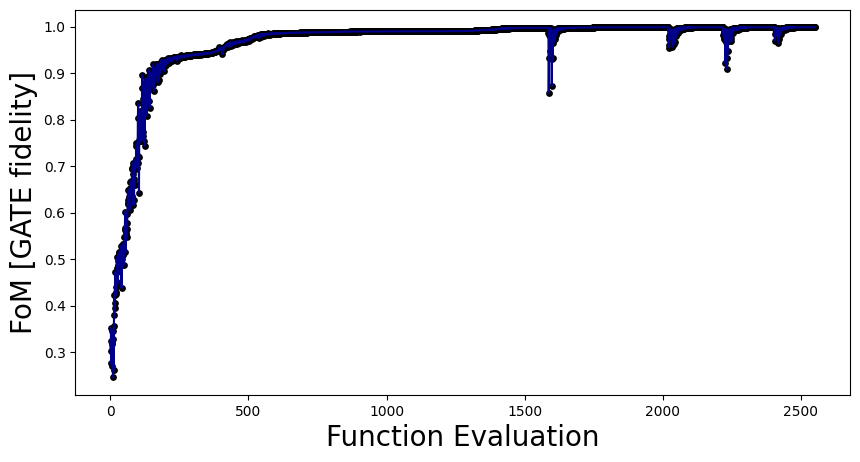

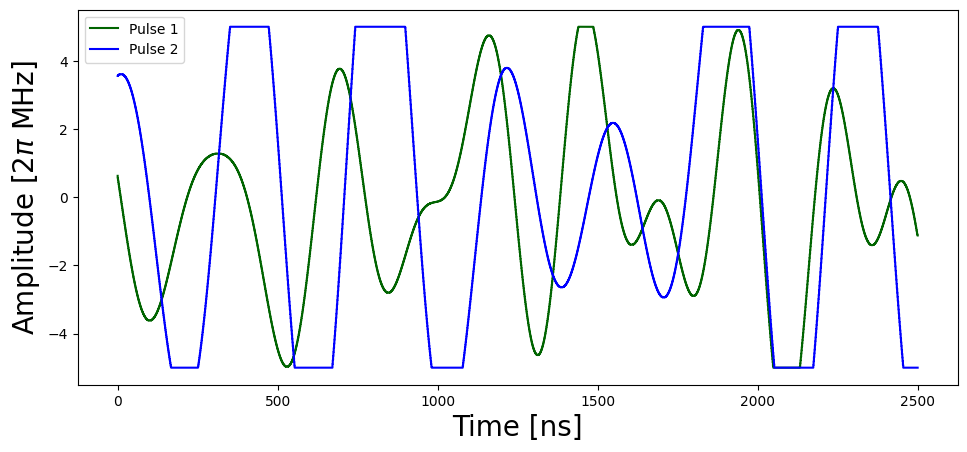

In [ ]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

omegaMHz = 5 # Rabi in MHZ to scale

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
#plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM [GATE fidelity]', fontsize=20)
plt.savefig('FoM_azz_1MHZ.png')  # Save as PNG

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
# Pulses amplitudes are recomputed in 2*pi MHZ units
pulse0, timegrid = controls["pulses"][0], controls["timegrids"][0]
pulse1, timegrid1 = controls["pulses"][1], controls["timegrids"][1]

# Plot the pulse over time
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse0*omegaMHz, color='darkgreen', linewidth=1.5, zorder=10, label = 'Pulse 1')
plt.step(timegrid, pulse1*omegaMHz, color='blue', linewidth=1.5, zorder=10, label='Pulse 2')
#plt.grid(False, which="both")
plt.xlabel('Time [ns]', fontsize=20)
plt.ylabel(r'Amplitude [2$\pi$ MHz]', fontsize=20)
plt.legend()
# plt.savefig('Optimal pulses_azz_1MHZ.png')  # Save as PNG